In [213]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [234]:
with open("/Users/anuraagsrivatsa/Documents/Capstone/EAV/EAV/processed_data_psd/subject2_processed_psd.pkl", "rb") as f:
    subject_eeg = pickle.load(f)

X = subject_eeg["features"]
y_onehot = subject_eeg["labels"]
if X.ndim == 3:
    X = X[..., np.newaxis]
print("X shape:", X.shape)
print("y (one-hot) shape:", y_onehot.shape)

X shape: (400, 30, 5, 1)
y (one-hot) shape: (400, 5)


In [235]:
mapping = np.array([
    [ 0.00,  0.00],   # 0 Neutral
    [-0.20, -0.10],   # 1 Sadness
    [-0.26,  0.3],   # 2 Anger
    [ 0.15,  0.05],   # 3 Happy
    [ 0.1, -0.15],   # 4 Calm
], dtype=np.float32)

y_va = y_onehot.dot(mapping)  # shape (n_samples, 2)

# Keep original class labels (integers) handy for confusion matrix
y_classes = np.argmax(y_onehot, axis=1)

In [236]:
train_ratio = 0.7
num_classes = y_onehot.shape[1]

X_train_list, yva_train_list, yclass_train_list = [], [], []
X_test_list,  yva_test_list,  yclass_test_list  = [], [], []

np.random.seed(42)  # for reproducibility of splits; you can remove if you don't want deterministic splits

for class_idx in range(num_classes):
    class_indices = np.where(y_classes == class_idx)[0]
    class_perm = np.random.permutation(class_indices)
    n_train = int(len(class_perm) * train_ratio)
    train_idx = class_perm[:n_train]
    test_idx  = class_perm[n_train:]

    X_train_list.append(X[train_idx])
    yva_train_list.append(y_va[train_idx])
    yclass_train_list.append(y_classes[train_idx])

    X_test_list.append(X[test_idx])
    yva_test_list.append(y_va[test_idx])
    yclass_test_list.append(y_classes[test_idx])

# concatenate
X_train = np.concatenate(X_train_list, axis=0)
yva_train = np.concatenate(yva_train_list, axis=0)
yclass_train = np.concatenate(yclass_train_list, axis=0)

X_test = np.concatenate(X_test_list, axis=0)
yva_test = np.concatenate(yva_test_list, axis=0)
yclass_test = np.concatenate(yclass_test_list, axis=0)

# shuffle each combined set
train_perm = np.random.permutation(len(X_train))
test_perm  = np.random.permutation(len(X_test))

X_train, yva_train, yclass_train = X_train[train_perm], yva_train[train_perm], yclass_train[train_perm]
X_test,  yva_test,  yclass_test  = X_test[test_perm],  yva_test[test_perm],  yclass_test[test_perm]

print("Train shapes:", X_train.shape, yva_train.shape, yclass_train.shape)
print("Test  shapes:", X_test.shape,  yva_test.shape,  yclass_test.shape)

Train shapes: (280, 30, 5, 1) (280, 2) (280,)
Test  shapes: (120, 30, 5, 1) (120, 2) (120,)


In [237]:
from tensorflow.keras import layers, models, regularizers

def resnet_block(x, filters, kernel=(3,3), stride=(1,1), l2=1e-4):
    reg = regularizers.l2(l2)
    shortcut = x
    x = layers.Conv2D(filters, kernel, strides=stride, padding='same', kernel_regularizer=reg, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)

    x = layers.Conv2D(filters, kernel, padding='same', kernel_regularizer=reg, use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # shortcut projection if shape mismatch
    if shortcut.shape[-1] != filters or stride != (1,1):
        shortcut = layers.Conv2D(filters, (1,1), strides=stride, padding='same', kernel_regularizer=reg, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('elu')(x)
    return x

def ResNet_EEG(input_shape=(30,5,1), num_outputs=2, num_classes=5, l2=1e-4):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)

    x = resnet_block(x, 32, l2=l2)
    x = resnet_block(x, 64, stride=(2,1), l2=l2)  # downsample channels dimension only
    x = resnet_block(x, 64, l2=l2)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(0.5)(x)

    # regression head (VA)
    va_out = layers.Dense(num_outputs, activation='linear', name='va')(x)
    # classification head
    cls_out = layers.Dense(num_classes, activation='softmax', name='cls')(x)

    model = models.Model(inputs=inp, outputs=[va_out, cls_out])
    return model


In [238]:
model = ResNet_EEG()
model.compile(optimizer='adam',
              loss={'va':'mse', 'cls':'categorical_crossentropy'},
              loss_weights={'va':1.0, 'cls':1},
              metrics={'va':'mae', 'cls':'accuracy'})
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 30, 5, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 30, 5, 32) │        288 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 5, 32) │        128 │ conv2d_114[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_109      │ (None, 30, 5, 32) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 30, 5, 32) │      9,216 │ activation_109[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 5, 32) │        128 │ conv2d_115[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_110      │ (None, 30, 5, 32) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 30, 5, 32) │      9,216 │ activation_110[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 5, 32) │        128 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 30, 5, 32) │          0 │ batch_normalizat… │
│                     │                   │            │ activation_109[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_111      │ (None, 30, 5, 32) │          0 │ add_39[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 15, 5, 64) │     18,432 │ activation_111[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 5, 64) │        256 │ conv2d_117[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_112      │ (None, 15, 5, 64) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 15, 5, 64) │     36,864 │ activation_112[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 15, 5, 64) │      2,048 │ activation_111[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 5, 64) │        256 │ conv2d_118[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 5, 64) │        256 │ conv2d_119[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 15, 5, 64) │          0 │ batch_normalizat

 Total params: 160,679 (627.65 KB)

 Trainable params: 159,847 (624.40 KB)

 Non-trainable params: 832 (3.25 KB)

In [239]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Number of classes (5 in your problem)
num_classes = y_onehot.shape[1]

# Convert integer class arrays to one-hot for the classification head
yclass_train_onehot = tf.keras.utils.to_categorical(yclass_train, num_classes)
yclass_test_onehot  = tf.keras.utils.to_categorical(yclass_test,  num_classes)

# Build label dictionaries for multi-output training
y_train_dict = {'va': yva_train, 'cls': yclass_train_onehot}
y_val_dict   = {'va': yva_test,  'cls': yclass_test_onehot}

# Callbacks
early_stopper = EarlyStopping(monitor='val_cls_accuracy', mode='max', patience=75, restore_best_weights=True, verbose=1)

# Fit
history = model.fit(
    X_train, y_train_dict,
    epochs=400,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, y_val_dict),
    callbacks=[early_stopper],
    verbose=2
)


Epoch 1/400
9/9 - 4s - 459ms/step - cls_accuracy: 0.3464 - cls_loss: 1.4485 - loss: 1.9545 - va_loss: 0.4529 - va_mae: 0.4827 - val_cls_accuracy: 0.2000 - val_cls_loss: 3.6152 - val_loss: 3.7550 - val_va_loss: 0.1023 - val_va_mae: 0.2771
Epoch 2/400
9/9 - 0s - 30ms/step - cls_accuracy: 0.4214 - cls_loss: 1.2652 - loss: 1.5092 - va_loss: 0.2027 - va_mae: 0.3416 - val_cls_accuracy: 0.2000 - val_cls_loss: 3.2696 - val_loss: 3.5156 - val_va_loss: 0.2065 - val_va_mae: 0.4108
Epoch 3/400
9/9 - 0s - 30ms/step - cls_accuracy: 0.4714 - cls_loss: 1.1812 - loss: 1.3936 - va_loss: 0.1646 - va_mae: 0.3141 - val_cls_accuracy: 0.2000 - val_cls_loss: 2.6522 - val_loss: 2.8857 - val_va_loss: 0.1994 - val_va_mae: 0.3709
Epoch 4/400
9/9 - 0s - 42ms/step - cls_accuracy: 0.5286 - cls_loss: 1.1397 - loss: 1.3156 - va_loss: 0.1328 - va_mae: 0.2705 - val_cls_accuracy: 0.2000 - val_cls_loss: 3.1879 - val_loss: 3.2930 - val_va_loss: 0.0718 - val_va_mae: 0.2317
Epoch 5/400
9/9 - 0s - 45ms/step - cls_accuracy: 0.

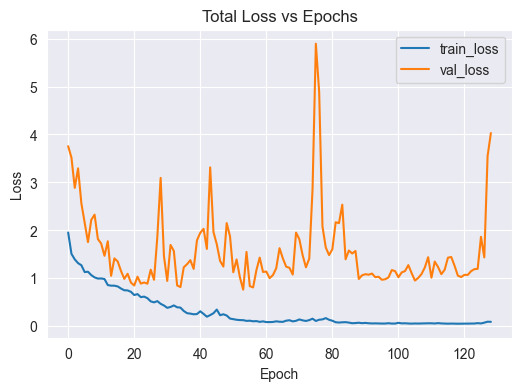

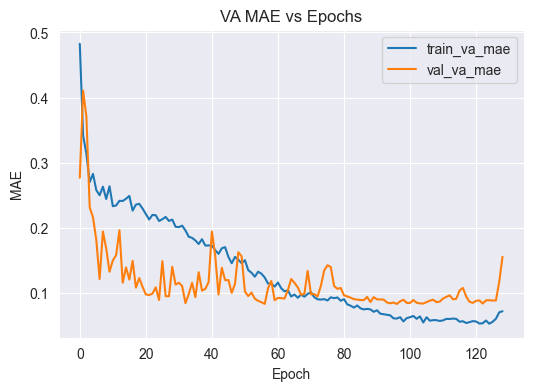

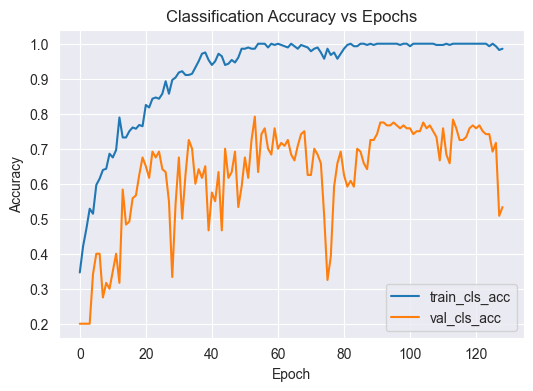

In [240]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Total Loss vs Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['va_mae'], label='train_va_mae')
plt.plot(history.history['val_va_mae'], label='val_va_mae')
plt.title('VA MAE vs Epochs'); plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['cls_accuracy'], label='train_cls_acc')
plt.plot(history.history['val_cls_accuracy'], label='val_cls_acc')
plt.title('Classification Accuracy vs Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.show()

Accuracy (classification head) : 0.7917
Accuracy (regression→prototype) : 0.5917
Accuracy (ensemble 0.90/0.10) : 0.7750

Classification Report (classification head):
              precision    recall  f1-score   support

     Neutral       0.77      1.00      0.87        24
     Sadness       0.71      0.62      0.67        24
       Anger       0.82      0.75      0.78        24
       Happy       0.84      0.88      0.86        24
        Calm       0.81      0.71      0.76        24

    accuracy                           0.79       120
   macro avg       0.79      0.79      0.79       120
weighted avg       0.79      0.79      0.79       120

Classification Report (regression→prototype):
              precision    recall  f1-score   support

     Neutral       0.42      0.83      0.56        24
     Sadness       0.88      0.29      0.44        24
       Anger       0.67      0.58      0.62        24
       Happy       0.87      0.54      0.67        24
        Calm       0.61     

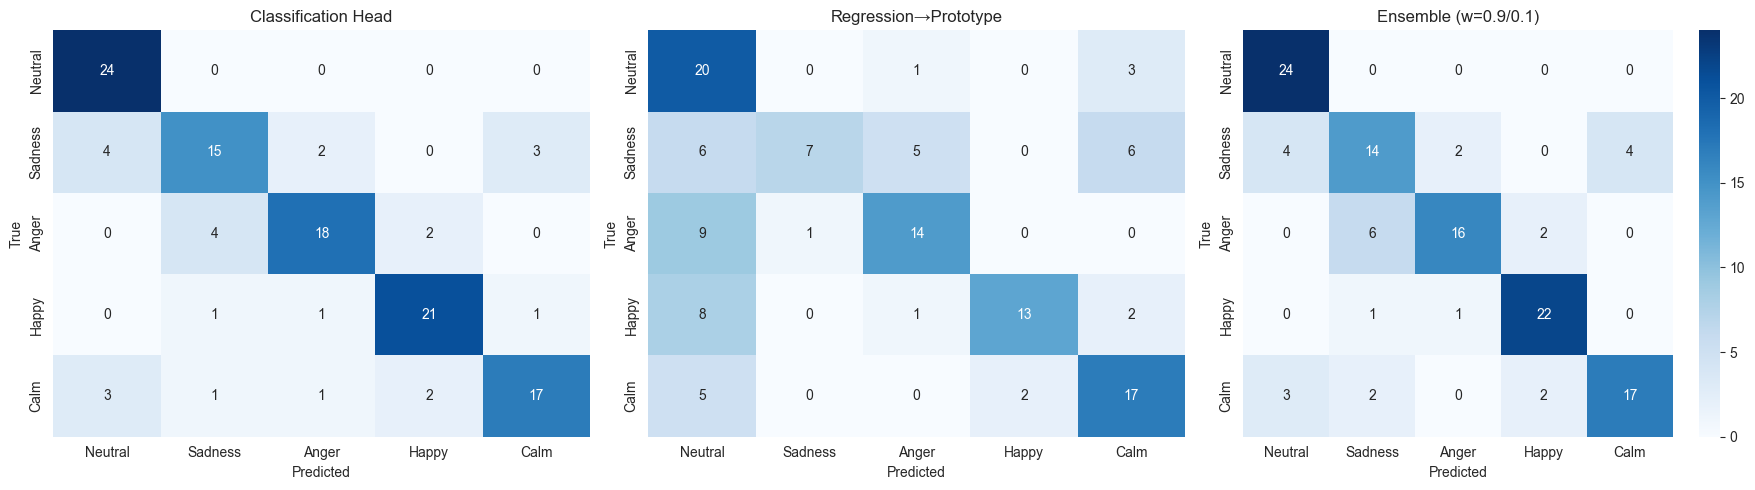

In [241]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

yva_pred, ycls_pred_probs = model.predict(X_test, verbose=0)
target_names = ['Neutral', 'Sadness', 'Anger', 'Happy', 'Calm']
# classification head predictions
y_pred_cls_head = np.argmax(ycls_pred_probs, axis=1)
y_true = yclass_test

# regression -> class soft-probabilities
prototypes = np.array(mapping)   # shape (5,2)
# compute euclidean distances
dists = np.linalg.norm(yva_pred[:, None, :] - prototypes[None, :, :], axis=2)   # (n_test, n_classes)

# convert distances to soft probabilities via softmax over negative distances
def softmax_rows(x, axis=1):
    e = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e / np.sum(e, axis=axis, keepdims=True)

p_reg = softmax_rows(-dists)   # regression-based soft probabilities (closer = larger prob)
y_pred_reg_head = np.argmax(p_reg, axis=1)

# weighted ensemble probabilities: 0.6 reg, 0.4 cls
w_reg, w_cls = 0.9, 0.1
p_comb = w_reg * p_reg + w_cls * ycls_pred_probs
y_pred_ensemble = np.argmax(p_comb, axis=1)

# -------------------------
# Compute accuracy and classification report for each method
# -------------------------
acc_cls = accuracy_score(y_true, y_pred_cls_head)
acc_reg = accuracy_score(y_true, y_pred_reg_head)
acc_comb = accuracy_score(y_true, y_pred_ensemble)

print(f"Accuracy (classification head) : {acc_cls:.4f}")
print(f"Accuracy (regression→prototype) : {acc_reg:.4f}")
print(f"Accuracy (ensemble {w_reg:.2f}/{w_cls:.2f}) : {acc_comb:.4f}\n")

print("Classification Report (classification head):")
print(classification_report(y_true, y_pred_cls_head, target_names=target_names, zero_division=0))
print("Classification Report (regression→prototype):")
print(classification_report(y_true, y_pred_reg_head, target_names=target_names, zero_division=0))
print("Classification Report (ensemble):")
print(classification_report(y_true, y_pred_ensemble, target_names=target_names, zero_division=0))

cm_cls = confusion_matrix(y_true, y_pred_cls_head)
cm_reg = confusion_matrix(y_true, y_pred_reg_head)
cm_comb = confusion_matrix(y_true, y_pred_ensemble)
cms = [cm_cls, cm_reg, cm_comb]
titles = ['Classification Head', 'Regression→Prototype', f'Ensemble (w={w_reg}/{w_cls})']

vmin = min(cm.min() for cm in cms)
vmax = max(cm.max() for cm in cms)

plt.figure(figsize=(18,5))
for i, (cm_i, title) in enumerate(zip(cms, titles), 1):
    ax = plt.subplot(1,3,i)
    sns.heatmap(cm_i, annot=True, fmt='d', cmap='Blues', vmin=vmin, vmax=vmax,
                xticklabels=target_names, yticklabels=target_names, cbar=(i==3))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
plt.tight_layout()
plt.show()

In [232]:
import numpy as np
import matplotlib.pyplot as plt

def plot_point(model, sample, true_label=None,
               prototypes=None, prototype_names=None,
               figsize=(7,7), inset_location=(0.72, 0.58, 0.25, 0.28),
               label_offset_scale=0.10, show_probs=True):
    """
    Improved plotting of a single sample:
      - model: a Keras model that returns [va_pred, cls_probs] or a dict
      - sample: shape (30,5,1) or (30,5)
      - true_label: optional int 0..4
      - prototypes: array-like shape (n_classes, 2); default uses `mapping` if available
      - prototype_names: list of names; default uses target_names if available
      - inset_location: [left, bottom, width, height] in figure coords for the prob bar
      - label_offset_scale: how far to offset label from prototype (fraction of axis range)
    """
    # defaults if not provided (will use variables from your session if present)
    if prototypes is None:
        try:
            prototypes = np.array(mapping)
        except NameError:
            raise ValueError("Please provide `prototypes` or define `mapping` in the session.")
    else:
        prototypes = np.array(prototypes)

    if prototype_names is None:
        try:
            prototype_names = list(target_names)
        except NameError:
            prototype_names = [f"C{i}" for i in range(len(prototypes))]

    # prepare sample in batch form
    s = np.array(sample)
    if s.ndim == 3:
        s_batch = s[None, ...]
    elif s.ndim == 2:
        s_batch = s[None, ..., np.newaxis]
    else:
        raise ValueError("sample must be shape (30,5,1) or (30,5)")

    # robust prediction extraction (handles list, tuple, dict, single-array)
    preds = model.predict(s_batch, verbose=0)
    if isinstance(preds, (list, tuple)):
        va_pred = preds[0]
        cls_probs = preds[1]
    elif isinstance(preds, dict):
        # try common keys
        if 'va' in preds and 'cls' in preds:
            va_pred = preds['va']
            cls_probs = preds['cls']
        else:
            # fall back to first two items
            keys = list(preds.keys())
            va_pred = preds[keys[0]]
            cls_probs = preds[keys[1]] if len(keys) > 1 else np.zeros((1, len(prototypes)))
    else:
        # single-array return (could be regression only)
        # assume preds shape (1,2) for VA; then we don't have class probs
        arr = np.array(preds)
        if arr.shape[-1] == 2:
            va_pred = arr
            cls_probs = np.zeros((1, len(prototypes)))
        else:
            raise ValueError("Couldn't interpret model.predict output. Provide a model that returns [va, cls_probs] or a dict.")

    va_point = np.asarray(va_pred)[0].astype(float)      # (2,)
    cls_probs = np.asarray(cls_probs)[0].astype(float)   # (n_classes,)
    pred_class = int(np.argmax(cls_probs)) if cls_probs.sum() > 0 else None

    # Setup figure and axes
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # Determine axis limits with padding
    all_x = np.concatenate([prototypes[:,0], [va_point[0]]])
    all_y = np.concatenate([prototypes[:,1], [va_point[1]]])
    pad_x = max(0.2, (all_x.max() - all_x.min()) * 0.15)
    pad_y = max(0.2, (all_y.max() - all_y.min()) * 0.15)
    x_min, x_max = all_x.min() - pad_x, all_x.max() + pad_x
    y_min, y_max = all_y.min() - pad_y, all_y.max() + pad_y
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Plot prototypes
    ax.scatter(prototypes[:,0], prototypes[:,1], s=120, marker='o', edgecolor='k', linewidth=1.2, zorder=2)
    # smaller filled point to help visibility
    ax.scatter(prototypes[:,0], prototypes[:,1], s=40, marker='o', zorder=3)

    # place labels with offsets to reduce overlap
    x_range = x_max - x_min
    y_range = y_max - y_min
    offset_mag_x = x_range * label_offset_scale
    offset_mag_y = y_range * label_offset_scale

    for i, p in enumerate(prototypes):
        px, py = float(p[0]), float(p[1])
        # offset direction: away from origin and slightly biased by sign to avoid piling up at center
        dir_x = np.sign(px) if px != 0 else 1.0
        dir_y = np.sign(py) if py != 0 else 1.0
        # normalized diagonal offset
        norm = np.hypot(dir_x, dir_y)
        label_x = px + (dir_x / norm) * offset_mag_x
        label_y = py + (dir_y / norm) * offset_mag_y

        # fallback: if label would be outside axis, nudge inward
        label_x = np.clip(label_x, x_min + 0.02 * x_range, x_max - 0.02 * x_range)
        label_y = np.clip(label_y, y_min + 0.02 * y_range, y_max - 0.02 * y_range)

        bbox = dict(boxstyle="round,pad=0.3", fc="w", ec="gray", alpha=0.9, linewidth=0.8)
        ax.annotate(f"{i}: {prototype_names[i]}", xy=(px, py), xytext=(label_x, label_y),
                    arrowprops=dict(arrowstyle="-", lw=0.6, color='gray', alpha=0.6),
                    bbox=bbox, fontsize=9, zorder=4)

    # Plot predicted VA point
    ax.scatter(va_point[0], va_point[1], s=160, marker='X', edgecolor='k', linewidth=1.2, zorder=6)
    ax.annotate(f"Pred VA\n({va_point[0]:.2f}, {va_point[1]:.2f})", xy=(va_point[0], va_point[1]),
                xytext=(va_point[0] + 0.03 * x_range, va_point[1] - 0.03 * y_range),
                bbox=dict(boxstyle="round,pad=0.2", fc="#fff7e6", ec="k", alpha=0.95),
                fontsize=9, zorder=7)

    # Highlight predicted class prototype (halo)
    if pred_class is not None:
        halo_x, halo_y = prototypes[pred_class]
        ax.scatter(halo_x, halo_y, s=420, facecolors='none', edgecolor='red', linewidth=2.0, alpha=0.9, zorder=5)

    # Print text info in console
    if true_label is not None:
        print(f"True Label:      {true_label} ({prototype_names[true_label]})")
    if pred_class is not None:
        print(f"Predicted Class (classification head): {pred_class} ({prototype_names[pred_class]})  prob={cls_probs[pred_class]:.3f}")
    print(f"Predicted VA (regression): ({va_point[0]:.3f}, {va_point[1]:.3f})")

    # Add axes lines, labels, grid
    ax.axhline(0, color='gray', linewidth=0.6, zorder=0)
    ax.axvline(0, color='gray', linewidth=0.6, zorder=0)
    ax.set_xlabel('Valence')
    ax.set_ylabel('Arousal')
    ax.set_title('Predicted Valence/Arousal and Prototypes')
    ax.grid(True, alpha=0.3)

    # Add inset bar of class probabilities (upper-right by default)
    if show_probs:
        # place inset as figure coords: left, bottom, width, height
        left, bottom, width, height = inset_location
        ax_inset = fig.add_axes([left, bottom, width, height])
        classes = list(range(len(cls_probs)))
        ax_inset.bar(classes, cls_probs, tick_label=prototype_names)
        ax_inset.set_ylim(0, 1.0)
        ax_inset.set_title('Class probs', fontsize=9)
        ax_inset.tick_params(axis='x', labelrotation=45, labelsize=8)
        ax_inset.set_ylabel('p', fontsize=8)
        for spine in ax_inset.spines.values():
            spine.set_linewidth(0.6)

    plt.tight_layout()
    plt.show()


True Label:      1 (Sadness)
Predicted Class (classification head): 4 (Calm)  prob=0.875
Predicted VA (regression): (-0.043, -0.052)


/var/folders/8g/lw57w3cx1zd7z20y9l937bx40000gn/T/ipykernel_49539/2382690881.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


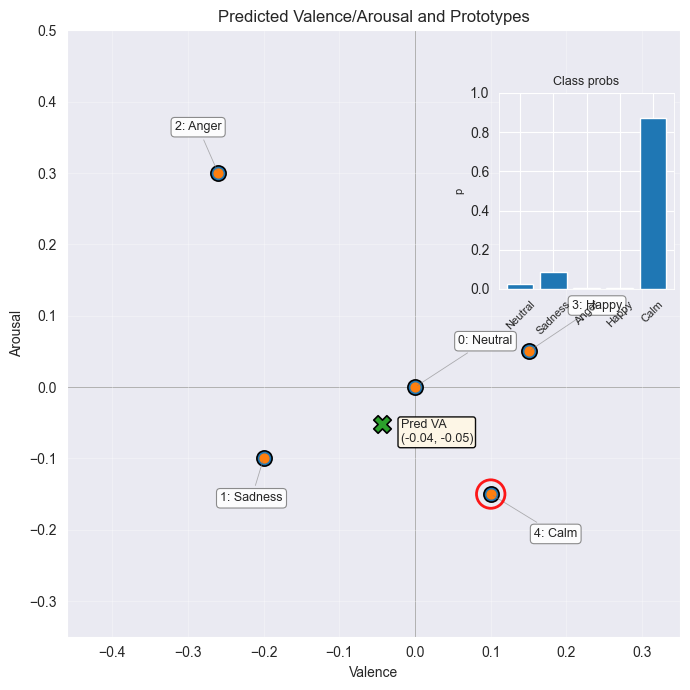

In [233]:
plot_point(model, X_test[111], true_label=yclass_test[111])

In [121]:
s = np.array(X_test[100])
if s.ndim == 3:
    s_batch = s[None, ...]
elif s.ndim == 2:
    s_batch = s[None, ..., np.newaxis]
else:
    raise ValueError("sample must be shape (30,5,1) or (30,5)")

test = model.predict(s_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [122]:
test

[array([[-0.27674723,  0.1759861 ]], dtype=float32),
 array([[0.00063733, 0.6213369 , 0.28239506, 0.08048214, 0.01514853]],
       dtype=float32)]